# Тeматическое моделирование

In [1]:
! pip install spacy -q
! python -m spacy download ru_core_news_sm -q


2023-06-29 18:22:08.886153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 18:22:12.852738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


Подключаем библиотеки.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from gensim.models import LsiModel
import nltk
nltk.download('stopwords')

import json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory data analysis

Укажем путь к файлу.

In [3]:
!gdown 1WbUGXxfXmWnBy93DdFQdT28s8eZfZSjj

Downloading...
From: https://drive.google.com/uc?id=1WbUGXxfXmWnBy93DdFQdT28s8eZfZSjj
To: /content/clean_posts.csv
100% 3.79M/3.79M [00:00<00:00, 92.5MB/s]


Загрузим данные в dataframe.

In [4]:
df = pd.read_csv('/content/clean_posts.csv')
df.head()

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
0,https://www.linkedin.com/in/varvara-kulmeteva-...,senior web developer,Varvara Kulmeteva,Senior Web Developer - IBS InfinitySoft,IBS,Навыки: ReactJS · JavaScript · HTML · CSSНавык...,10.0,"Москва, Московская область, Россия",0,NaN,NaN,NaN,NaN
1,https://www.linkedin.com/in/rauventa,senior frontend,Ilya Moiseenko,"LOOKING FOR ""Senior/Lead Frontend (React) Deve...",Centicore,"Ilya, React Developer from Moscow.Ilya, React ...",8.0,"Москва, Москва, Россия",1,Я только что получил(а) значок за навык «JavaS...,1.0,NaN,NaN
2,https://www.linkedin.com/in/denis-kuchkildin,middle data analyst,Denis Kuchkildin,Data Analyst at X5 Group,X5 Group,I have a strong engineering background and mor...,6.0,"Москва, Москва, Россия",1,Hi everyone - I am looking for a new role and ...,NaN,NaN,NaN
3,https://www.linkedin.com/in/ACoAAC4yJzEB4TjXkJ...,senior ML engineer,Ian Silantev,MSc Data Science in University of East London ...,Neurospot,"Absolutely in love with Data Science, AI and M...",2.0,"Тбилиси, Грузия",0,NaN,NaN,NaN,NaN
4,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,Finding a job for trainees and juniors is a ch...,1.0,NaN,NaN


Оставим только посты на русском.

In [5]:
df = df[df.post_text.astype('str').map(lambda x: x.isascii())==False]

In [6]:
df.post_text.value_counts()

Здравствуйте, я в поиске новой карьерной возможности и буду признателен(а) за вашу поддержку. Заранее благодарю за все рекомендации контактов, советы или возможности, которые вы можете предложить. #OpenToWork                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Посмотрим на размер выборки.

In [7]:
df.shape

(709, 13)

Посчитаем колличество уникальных имен ссылок на аккаунты.

In [8]:
df.account_link.nunique()

188

188 ссылок на аккаунты.

**Посмотрим на числянные признаки.**

In [9]:
df.describe()

,experience,posts_cnt,reaction_cnt,comments_cnt,repost_cnt
count,708.000000,709.000000,622.000000,341.000000,346.000000
mean,12.439266,31.559944,4.853698,3.882698,4.242775
std,69.113833,48.111463,2.642306,2.486024,2.704589
min,0.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,4.000000,2.000000,2.000000,2.000000
50%,5.000000,11.000000,5.000000,3.000000,4.000000
75%,9.000000,37.000000,7.000000,6.000000,7.000000
max,853.000000,308.000000,9.000000,9.000000,9.000000


# Experience - опыт.

Очевидно, что есть выбросы по опыту. Ну никак больше 100 лет у нас не может быть в этих данных. Тем более 800 лет. Данный признак мы не оцениваем. Посмотрим сколько таких строк.

In [10]:
len(df[df.experience>100])

7

Посмотрим, есть ли посты у людей сопытом более 100 лет.

In [11]:
df[df.experience>100].posts_cnt.value_counts(dropna=False)

4    4
8    3
Name: posts_cnt, dtype: int64

Посты есть, не будем их удалять. Но посмотри на распределение без этих значений.

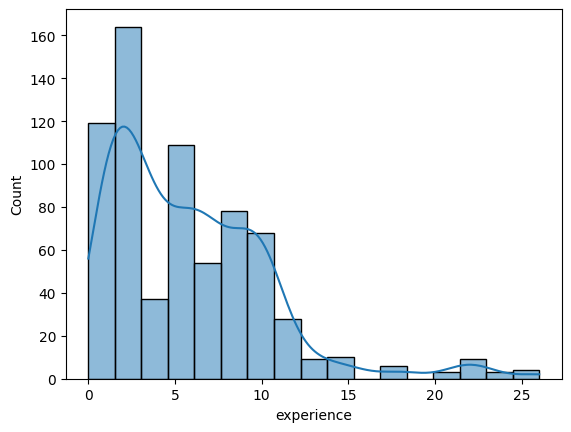

In [12]:
sns.histplot(df.query('experience<100')['experience'], kde=True)
plt.show()

Как видно, большинство пользователей с опытом 10 лет. Резкий пик у 12. И еще более резкий спад. Людей с опытом более 30 лет практически нет.

# posts_cnt - кол-во постов.

Посмотрим на распредление по кол-ву постов.

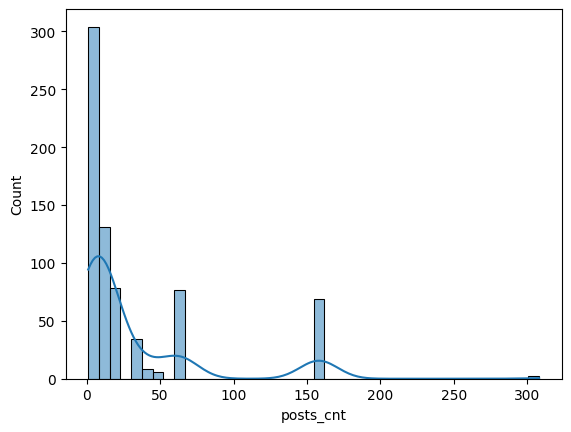

In [13]:
sns.histplot(df.posts_cnt, kde=True)
plt.show()

Большинство профилей не имеют постов. Есть единичные пики у 150 и 300. Посмотрим, сколько у нас таких пользователей.

In [14]:
df[df.posts_cnt>100]['name'].nunique()

2

2 пользователя с таким кол-вом постов.

# reaction_cnt - кол-во реакций.

Посмотрим на распределение reaction_cnt.

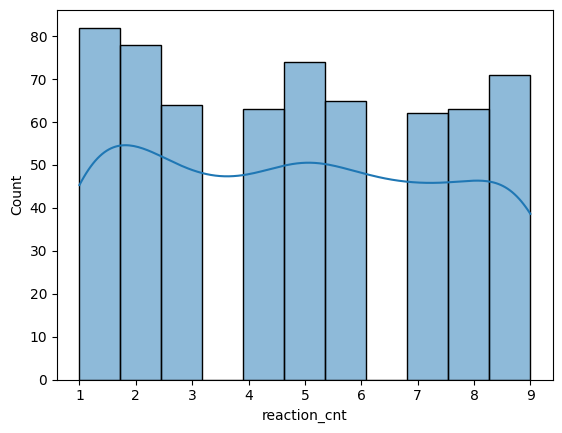

In [15]:
sns.histplot(df.reaction_cnt, kde=True)
plt.show()

Здесь график больше похож на равномерное распределение. Есть и провалы, конечно. Посмотрим сколько постов без реакций.

In [16]:
df.reaction_cnt.value_counts(dropna=False)

NaN    87
1.0    82
2.0    78
5.0    74
9.0    71
6.0    65
3.0    64
4.0    63
8.0    63
7.0    62
Name: reaction_cnt, dtype: int64

Получается, что около половины постов без реакций.

# comments_cnt - кол-во комментариев.

Посмотрим на распределение reaction_cnt.

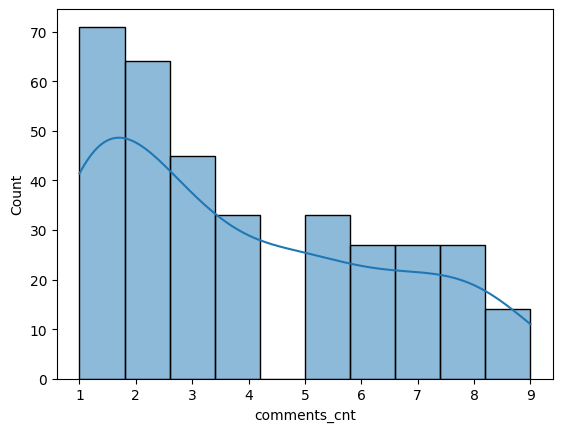

In [17]:
sns.histplot(df.comments_cnt, kde=True)
plt.show()

Здесь у нас пик у 1, далее спад. У большиства, конечно 0 в комментариях. Посмотрим, сколько их.

In [18]:
df.comments_cnt.value_counts(dropna=False)

NaN    368
1.0     71
2.0     64
3.0     45
5.0     33
4.0     33
6.0     27
7.0     27
8.0     27
9.0     14
Name: comments_cnt, dtype: int64

3/4 постов без комментариев.

# repost_cnt - кол-во репостов.

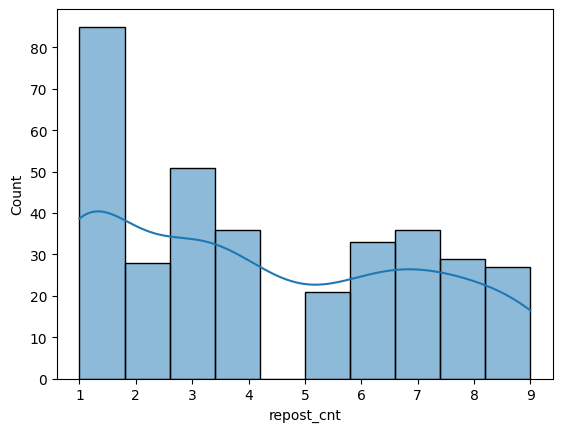

In [19]:
sns.histplot(df.repost_cnt, kde=True)
plt.show()

Здесь у нас пик у 1, далее спад. У большиства, конечно 0 в комментариях. Посмотрим, сколько их.

In [20]:
df.repost_cnt.value_counts(dropna=False)

NaN    363
1.0     85
3.0     51
7.0     36
4.0     36
6.0     33
8.0     29
2.0     28
9.0     27
5.0     21
Name: repost_cnt, dtype: int64

3/4 постов без репостов.

Распределение репостов и комментариев очень похожи. Инетересно посмотреть, как они зависят друг от друга.

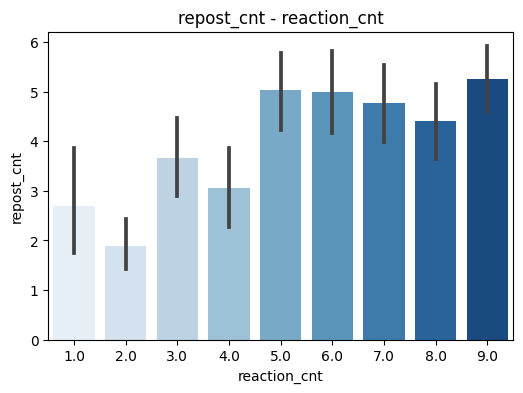

In [21]:
plt.figure(figsize=(6,4))
sns.barplot(x='reaction_cnt', y='repost_cnt', data = df, palette='Blues')
plt.title('repost_cnt - reaction_cnt')
plt.show()

Все также логично, с увеличением кол-ва реакций на пост, увеличивается кол-во тех,к то репостит.

Посмотрим связано ли кол-во репостов с реакциями.

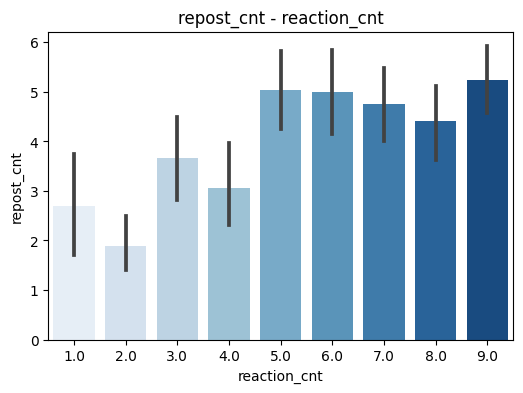

In [22]:
plt.figure(figsize=(6,4))
sns.barplot(x='reaction_cnt', y='repost_cnt', data = df, palette='Blues')
plt.title('repost_cnt - reaction_cnt')
plt.show()

In [23]:
df.head()

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
1,https://www.linkedin.com/in/rauventa,senior frontend,Ilya Moiseenko,"LOOKING FOR ""Senior/Lead Frontend (React) Deve...",Centicore,"Ilya, React Developer from Moscow.Ilya, React ...",8.0,"Москва, Москва, Россия",1,Я только что получил(а) значок за навык «JavaS...,1.0,NaN,NaN
6,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,Привiт!👋 Я у пошуках роботи Product Manager та...,6.0,5.0,8.0
8,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,"Усім привіт!Розпочинаємо збір, є запит на квад...",5.0,1.0,5.0
9,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,"Моя хорошая подруга - фотограф, как и часть ук...",3.0,NaN,1.0
12,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,Всем привет!Хочешь начать изучение испанского ...,5.0,NaN,1.0


Проверим, есть ли в данных рекрутеры.

In [24]:
df[df['title'].str.contains('Recruit')==True]

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt


Есть такие. Посмотрим сколько таких аккаунтов.

In [25]:
len(df[df['title'].str.contains('Recruiter')==True])

0

Почистим данные от рекрутеров.

In [26]:
df = df[df['title'].str.contains('Recruiter')==False]

In [27]:
df.shape

(709, 13)

In [28]:
df.account_link.nunique()

188

Посмотрим на должности наших специалистов.

In [29]:
df.title.unique()

array(['LOOKING FOR "Senior/Lead Frontend (React) Developer" VACANCY',
       'Senior Test Automation Engineer at GlobalLogic',
       'Frontend | Full Stack Developer (JavaScript • TypeScript • React • Redux • NodeJS)',
       'Frontend developer',
       'Frontend Developer (HTML, CSS, JS, React, Redux)',
       'FrontEnd developer. React, Typescript, Redux, MobX, HTML, CSS, JS.',
       'Software frontend engineer',
       'Frontend Developer (JavaScript, React.js, TypeScript)',
       'Frontend developer | React | TS | JS',
       'Frontend Developer React/Next | TypeScript/Javascript(ES6+)',
       'Frontend Engineer - Vue.js, Nuxt, Pinia, Vuex, Quasar, Strapi',
       'Frontend Web (ES6+, React.JS, Node.JS ) Developer',
       'Middle Frontend Developer',
       'Frontend Developer – ООО "АйТи Сервис Менеджмент"',
       'Frontend Разработчик (Vue/React) | Заинтересован в Релокации/Удалённой работе',
       'Frontend developer JS', 'Frontend Developer',
       'Frontend разработч

In [30]:
mistakes=['Ищу срочно: Главного геолога (изыскания)! Локация -Москва либо Тольятти', '17000+ | Комплексная помощь в поиске работы | im-konsalting.ru  | mail@im-konsalting.ru | WhatsApp/Telegram: 79643223069',
            'Руководитель подразделений маркетинга и стратегического развития в крупных компаниях на B2C рынке | 11 000+','Строю крутые отделы продаж. Обучаю в формате «Реалити». Я - Владимир Якуба',
            'Специалист по найму персонала – V Kontakte LLC',]
df=df.query('title not in @mistakes')

Итого  наш предобработанный файл:

In [31]:
df.shape

(709, 13)

Это 2039 строк.

In [32]:
df.account_link.nunique()

188

782 уникальных пользователей.

In [33]:
df

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
1,https://www.linkedin.com/in/rauventa,senior frontend,Ilya Moiseenko,"LOOKING FOR ""Senior/Lead Frontend (React) Deve...",Centicore,"Ilya, React Developer from Moscow.Ilya, React ...",8.0,"Москва, Москва, Россия",1,Я только что получил(а) значок за навык «JavaS...,1.0,NaN,NaN
6,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,Привiт!👋 Я у пошуках роботи Product Manager та...,6.0,5.0,8.0
8,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,"Усім привіт!Розпочинаємо збір, є запит на квад...",5.0,1.0,5.0
9,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,"Моя хорошая подруга - фотограф, как и часть ук...",3.0,NaN,1.0
12,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,Всем привет!Хочешь начать изучение испанского ...,5.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047,https://www.linkedin.com/in/sky3ddd,senior backend,Alex Stakhanov,"Senior Backend Developer – StreamLayer Inc., e...",StreamLayer Inc.,"Currently I use: Typescript, gRPC, TypeORM, Po...",26.0,"Тула, Тульская область, Россия",7,"С удовольствием сообщаю, что я получил(а) новы...",9.0,NaN,NaN
2048,https://www.linkedin.com/in/sky3ddd,senior backend,Alex Stakhanov,"Senior Backend Developer – StreamLayer Inc., e...",StreamLayer Inc.,"Currently I use: Typescript, gRPC, TypeORM, Po...",26.0,"Тула, Тульская область, Россия",7,"С удовольствием сообщаю, что я получил(а) новы...",2.0,1.0,NaN
2050,https://www.linkedin.com/in/sky3ddd,senior backend,Alex Stakhanov,"Senior Backend Developer – StreamLayer Inc., e...",StreamLayer Inc.,"Currently I use: Typescript, gRPC, TypeORM, Po...",26.0,"Тула, Тульская область, Россия",7,"С удовольствием сообщаю, что я получил(а) новы...",1.0,NaN,NaN
2058,https://www.linkedin.com/in/evgenymelnik,senior backend,Evgeny Melnik,software engineer,DzenLab,Головная компания федеральной розничной сети м...,14.0,"Краснодарский край, Россия",2,"Ну что, java рулит :)С начала года в режиме ин...",1.0,3.0,NaN


## Подготовка текстов

Токенизацию и лемматизацию текстов.

Устанавливаем либу и качаем русскоязычную модель _ru_core_news_sm_.

In [34]:
model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

Складываем все посты в один список

In [35]:
df.post_text.isna().sum()

0

In [36]:
df["post_text"] = df["post_text"].dropna()

In [37]:
df["post_text"]  = df["post_text"] .astype('str')

Посмотрим на кол-во символов в постах.

In [38]:
df["symbols"] = [len(x) for x in df['post_text']]

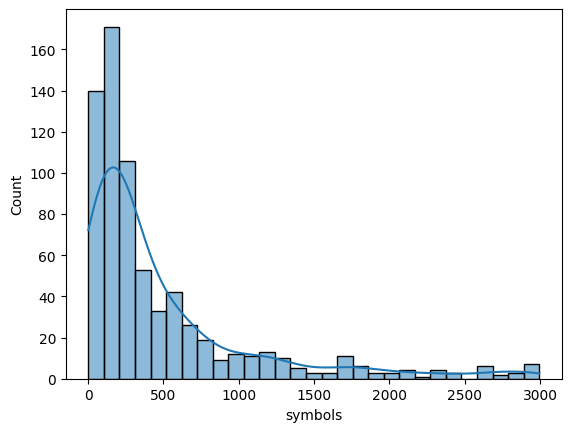

In [39]:
sns.histplot(df.symbols, kde=True)
plt.show()

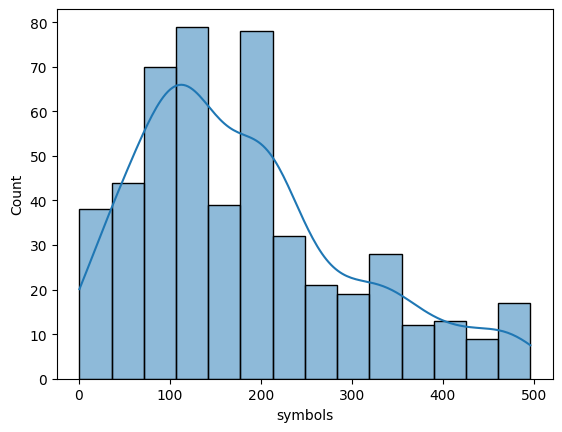

In [40]:
sns.histplot(df[df.symbols<=500].symbols, kde=True)
plt.show()

In [41]:
df[df.symbols<=50]

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt,symbols
71,https://www.linkedin.com/in/valeriy-nepluev-89...,frontend,Valeriy Nepluev,"Frontend Engineer - Vue.js, Nuxt, Pinia, Vuex,...",All3dmodels,Навыки: JavaScript · vue · nuxt · pinia · vuex...,3.0,"Республика Татарстан, Россия",4,К-коварство))),2.0,8.0,1.0,14
77,https://www.linkedin.com/in/oleg-kozlov-4191a0217,frontend,Oleg Kozlov,Middle Frontend Developer,ФГУП Главный радиочастотный центр,I work on Angular. Also created business proje...,3.0,"Москва, Москва, Россия",14,Всем бодрого утра среды!,NaN,NaN,NaN,24
82,https://www.linkedin.com/in/oleg-kozlov-4191a0217,frontend,Oleg Kozlov,Middle Frontend Developer,ФГУП Главный радиочастотный центр,I work on Angular. Also created business proje...,3.0,"Москва, Москва, Россия",14,Жизненно 😁,NaN,NaN,NaN,10
136,https://www.linkedin.com/in/sergeyromanovv,frontend,Sergey Romanov,Frontend Developer experienced in Agile web de...,ATG,"Ищу работу на позицию frontend-разработчика, у...",1.0,Россия,3,#humor#сПросторовИнтернета,7.0,2.0,7.0,26
138,https://www.linkedin.com/in/alenasafronova,frontend,Алена Сафронова,"Frontend Developer (React, Redux, JS)",Ruso,"Стек:Front-end: JS (ES6), React, Redux, TypeSc...",3.0,"Москва, Москва, Россия",2,😁,1.0,NaN,NaN,1
139,https://www.linkedin.com/in/alenasafronova,frontend,Алена Сафронова,"Frontend Developer (React, Redux, JS)",Ruso,"Стек:Front-end: JS (ES6), React, Redux, TypeSc...",3.0,"Москва, Москва, Россия",2,"Что правда, то правда)",5.0,5.0,4.0,23
159,https://www.linkedin.com/in/baremantar,frontend,Timur Asanov,Frontend developer,Affarts,"Hi!My start on frontend ""road"" has begun sprin...",2.0,Россия,3,Шпаргалка по JavaScript #javascript,8.0,1.0,4.0,35
180,https://www.linkedin.com/in/%D0%B0%D0%BB%D0%B5...,frontend,Алексей Риконвальд,Frontend React / Backend .Net Developer,Сейлз-хаус «Газпром-Медиа»,"Хей) Я Fullstack разработчик, на фронтенде раб...",2.0,"Москва, Москва, Россия",3,- Как у вас дела с С++?- Он меня ненавидит.,2.0,NaN,NaN,43
239,https://www.linkedin.com/in/denyacore,backend,Денис Шестиперов,Python Developer | backend,Пилигрим,На предыдущем месте работы утратил интерес к е...,1.0,"Рыбинск, Ярославская область, Россия",8,звучит как план#it #memes #humor,3.0,NaN,1.0,32
240,https://www.linkedin.com/in/denyacore,backend,Денис Шестиперов,Python Developer | backend,Пилигрим,На предыдущем месте работы утратил интерес к е...,1.0,"Рыбинск, Ярославская область, Россия",8,"найди одно маааленькое ""но""#it #memes #humor",1.0,NaN,NaN,44


In [42]:
texts = df["post_text"].tolist()

Выполняем лемматизацию текстов.

In [43]:
res = []
for doc in model.pipe(texts, disable=["tagger", "parser"]):
    res.append([token.lemma_ for token in doc])

In [44]:
with open("lemmas.json", "w") as fid:
    json.dump({"lemmas": res}, fid)

Смотрим на результат - случайным образом сэмплируем несколько примеров

In [45]:
", ".join(res[np.random.randint(len(res))])

'здравствовать, ,, я, в, поиск, новый, карьерный, возможность, и, быть, признателен(а, ), за, ваш, поддержка, ., заранее, благодарить, за, весь, рекомендация, контакт, ,, совет, или, возможность, ,, которые, вы, мочь, предложить, ., #, opentowork'

In [46]:
", ".join(res[np.random.randint(len(res))])

'в, поиск, крутой, специалист, (, г., алматы):1, ), front, -, end, разработчик, react, /, middle, 2, ), системный, аналитик, 3, ), qa, tester, (, middle)cv, можно, отправлять, в, telegram, :, @assyl02всем, заранее, спасибо, 🤗,  , #, cv, #, react, #, qa, #, front'

In [47]:
", ".join(res[np.random.randint(len(res))])

"hit, a, stone, wall, and, don't, know, how, to, get, to, the, next, level?sometimes, it, 's, enough, to, strengthen, your, team, to, get, more, and, better, work, done, ., we'll, help, you, overcome, the, barrier, ,, giving, you, a, shoulder, to, lean, on, and, take, on, some, of, the, work, related, to, the, project, management, and, development, ., in, our, work, ,, we, use, an, approach, that, allows, different, teams, (, dev, team, ,, devops, team, ,, qa, team, ,, management, ), to, work, independently, of, each, other, ,, while, exchanging, the, information, necessary, for, effective, collaboration, ., the, workflow, is, the, same, for, each, team, ,, whereby, :, \xa0\xa0\xa0, •, the, task, setting, process, is, standardized, ., \xa0\xa0\xa0, •, roles, and, responsibilities, are, defined, for, all, participants, ., \xa0\xa0\xa0, •, the, process, of, interaction, between, the, teams, is, clearly, defined, ., \xa0\xa0\xa0, •, the, same, tool, is, used, for, creating, and, keeping, 



Удалим знаки препинания, цифры и слова, содержащие цифры. Для это соберём регулярное выражение, которое подходит для любого слова, состоящего из букв кирилицы.



In [48]:
word_pattern = re.compile("^[а-яА-ЯёЁ]*$")

In [49]:
def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

In [50]:
corpus = list(map(remove_symbols, res))

In [51]:
", ".join(corpus[np.random.randint(len(corpus))])

'всем, привет, пойти, уже, второй, месяц, мой, активный, поиск, работа, за, плечо, собеседование, и, огромный, количество, отказ, до, просмотр, резюме, в, голова, возникать, мысль, что, никогда, не, найти, работа, но, я, не, сдаваться, ни, на, минуточка, и, идти, далёкий, в, бой, готовый, подвинуть, свой, рамка, и, ожидание, готовый, откликаться, на, позиция, джуна, Просто, просить, обратить, ваш, внимание, на, себя, вдруг, я, тот, за, репосты, и, лайк'

Выглядит гораздо лучше.

## Векторизация текстов

Чтобы уменьшить размерность получаемой матрицы, добавим исключение стоп-слов.

In [52]:
stop_words = stopwords.words('russian')
print(stop_words)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [53]:
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.9)

Т.е. TfIdfVectorizer принимает на вход список предложений, поэтому необходимо объединить списки слов, составляющих корпус, в предложения.

In [54]:
docs = [" ".join(tokens) for tokens in corpus]
docs[:3]

['я только что значок за навык кто хотеть быть следующий пройти тест на проверка навык',
 'я у пошуках роботи тот працюю щоденно над собою тот що я шукаю робот робот в або просто роботу на разовый можливий на випробувальний що тот розвиток тот команда що тот час я быть дуже вдячний за будь яку допомогу в мого резюме тот за на початку мого новый шляху тот додаткова тут',
 'запит на квадрокоптер для з бригади де служить найкращий друг брать участь у херсон а зараз виконують завдання на донецькому напрямку на загальна сума збору гривень посиланний на картки за допомогу тот раз до перемоги фото чека збору будуть до пост']

In [58]:
docs = list(filter(None, docs))

In [59]:
x = tfidf.fit_transform(docs)

In [60]:
x.shape

(533, 299)

Теперь составим словарь {id_токена: токен} - он пригодится нам позднее.

In [61]:
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

## LDA

Теперь можем запустить алгоритм LDA. Зададим количество тем равное 5.

In [62]:
n_topics = 5

In [63]:
lda = LatentDirichletAllocation(n_components=n_topics, random_state=31)

In [64]:
topics = lda.fit_transform(x)

In [65]:
topics.shape

(533, 5)

### Ключевые слова

Теперь извлечём ключевые слова для каждой из 5 тем. В свойсте _components_ _ лежит матрица соответствия слов темам. Пройдёмся по каждой из 5 выделенных тем и для каждой возьмём ТОП-20 слов.

По очереди пройдёмся по каждой теме (первое измерение массиа) и выберем ТОП-20 слов, наиболее характерных для этой темы. Потом по индексу слова обратимся к словарю и узнаем, что это за слово.

In [66]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
стек, репостам, ваш, опыт, активный, благодарный, позиция, находиться, проект, очень, вакансия, резюме, лайк, разработчик, поиск, искать, рад, привет, работа, всем

 
Тема 2 :
вопрос, весь, время, свой, мочь, пост, тест, следующий, наш, нужный, работать, год, пройти, хотеть, команда, человек, опыт, навык, работа, это

 
Тема 3 :
поиск, которые, мочь, здравствовать, рекомендация, ваш, предложить, поддержка, компания, благодарить, карьерный, совет, контакт, заранее, начинать, должность, сообщать, удовольствие, новый, возможность

 
Тема 4 :
проект, делиться, создание, канал, хотеть, слово, управление, бесплатный, нам, изучение, система, английский, сделать, полезный, книга, текст, свой, написать, статья, язык

 
Тема 5 :
английский, нужный, день, последний, взять, удобный, посмотреть, привет, команда, мочь, несколько, весь, разработчик, поделиться, других, разработка, направление, дело, хороший, признателен

 


По полученным ключевым словам можно составить представление о содержании той или иной темы. Хотя иногда сочетания слов довольно странные )  

### Типичные статьи

Теперь для каждой темы возьмём по одному документу, который хорошо соответсвует этой теме. Для этого заглянем в массив _topics_.

In [67]:
for i in range(n_topics):
    doc_id = np.argmax(topics[:, i])
    print("Тема ", i)
    print(df.iloc[doc_id]["post_text"])
    print("\n")

Тема  0
Друзья, приветствую, я в поиске новой карьерной возможности и буду благодарен за вашу поддержку, лайки и репосты!Интересуюсь позицией Frontend-разработчика.Мой основной стек: JavaScript, React,Redux toolkit, HTML, CSS#opentowork #frontend #javascript #react #redux #toolkit #html #CSS #bootstrap #SASS #PostgreSQL #SQLite #Prisma #AJAX #TS


Тема  1
Лилия Бирюкова #наймає. Знаєте когось, кому це може бути цікаво?


Тема  2
Hi there! I`m currently looking for a job as a frontend-developer. If you`re hiring or know someone who`s hiring, please, contact me :) Thank you in advance#OpenToWork #frontend #frontenddeveloper #react #CV


Тема  3
Невозможно представить свою жизнь без знания английского языка. И его можно изучить самостоятельно.Делюсь с вами ресурсами, которые будут полезны для самостоятельного изучения английского языка. Бесплатные сайты для изучения грамматики:📌 https://lnkd.in/g75pjqPq📌 https://lnkd.in/gUYiNPYU📌 https://lnkd.in/gTBFVgWM📌 https://lnkd.in/gDYTcuv2Очень при

## LSA

А ещё вы всегда можете сделать шаг назад и дополнить модель. Например:
- пополнить список стоп-слов (просмотрите внимательно ключевые слова каждой из тем - нет ли там случайных слов?);
- изменить настройки Tf-idF;
- увеличить/уменьшить количество тем;
- обучать LDA чуть дольше;
- заменить LDA на другой алгоритм тематического моделирояни.

# Полезные ссылки

- [Вики](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

- [История о том, как прочитать 120 тысяч анекдотов и не рассмеяться раньше времени](https://habr.com/ru/companies/otus/articles/723306/)

- [Видеоурок "Анализ текстовых данных тематическое моделирование комментариев Вконтакте"](https://www.youtube.com/watch?v=0DnfzQdbwQw)

- [LDA в Sklearn](https://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html)

- [Topic Modeling разными алгоритмами](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

- [Более академическое описание тематического моделировния](http://www.machinelearning.ru/wiki/index.php?title=%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)